In [41]:
import os

import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as F

In [ ]:
%%bash

bash download-data.bash

In [20]:
# copied from https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#visualization-utilities
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [2]:
model = torchvision.models.segmentation.lraspp_mobilenet_v3_large(pretrained=True)
model.eval()
print("Number of parameters:", sum(p.numel() for p in model.parameters()))

Number of parameters: 3221538


In [22]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, train):
        self.dir = "data/val2017"
        img_names = os.listdir(self.dir)
        num_imgs = len(img_names)
        num_train_imgs = 8 * num_imgs // 10
        self.img_names = img_names[:num_train_imgs] if train else img_names[num_train_imgs:]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir, self.img_names[idx])
        image = torchvision.io.read_image(img_path)
        return image

train_data = torch.utils.data.DataLoader(CocoDataset(train=True), batch_size=1, shuffle=True)

In [11]:
semantic_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
semantic_class_to_index = {class_name: i for (i, class_name) in enumerate(semantic_classes)}

breaking early


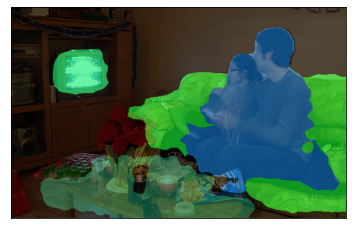

In [53]:
with torch.no_grad():
    for batch_int in train_data:
        batch = F.convert_image_dtype(batch_int, dtype=torch.float)
        normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        
        output = model(normalized_batch)['out']
        masks = torch.nn.functional.softmax(output, dim=1)
        num_classes = masks.shape[1]
        
        class_dim = 1
        mask_by_class = masks.argmax(1) == torch.arange(num_classes)[:, None, None, None]
        mask_by_class = einops.rearrange(mask_by_class, "class batch w h -> batch class w h")

        masked_imgs = [
            torchvision.utils.draw_segmentation_masks(img, masks=mask, alpha=.6)
            for img, mask in zip(batch_int, mask_by_class)
        ]
        show(masked_imgs)
        
        print("breaking early")      
        break